In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from calibrated_response.maxent.constraints import (
    ConstraintSet,
    ProbabilityConstraint,
    MeanConstraint,
    QuantileConstraint,
)
from calibrated_response.maxent.solver import MaxEntSolver, SolverConfig

# Set up plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 4)

# MaxEntropy Solver Testing

This notebook tests the maximum entropy solver by:
1. Creating various constraint scenarios
2. Solving for the maximum entropy distribution
3. Visualizing the results and checking constraint satisfaction

## Test 1: Simple Mean Constraint

First, let's test with a single mean constraint. With only a mean constraint, 
the maximum entropy distribution should be exponential-like.

Target mean: 30
Actual mean: 30.00
Entropy: 3.6576
Total violation: 0.000194


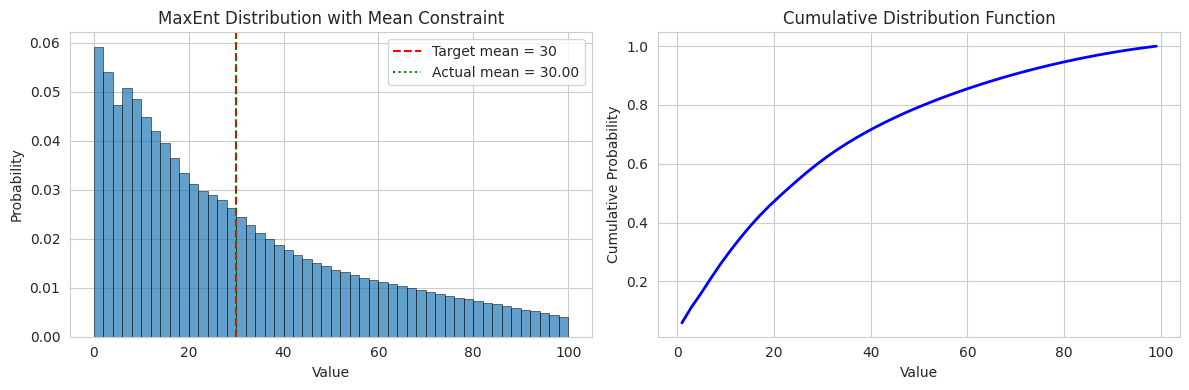

In [2]:
# Test 1: Single mean constraint
domain_min, domain_max = 0, 100
n_bins = 50
target_mean = 30

# Create constraint set
constraint_set = ConstraintSet(
    domain_min=domain_min,
    domain_max=domain_max,
    n_bins=n_bins,
)
constraint_set.add_mean_constraint(mean=target_mean, confidence=1.0)

# Configure and run solver
config = SolverConfig(verbose=False, regularization=0.001)
solver = MaxEntSolver(config)
distribution, info = solver.solve(constraint_set)

# Calculate results
bin_edges = constraint_set.bin_edges
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
actual_mean = np.sum(distribution * bin_centers)

print(f"Target mean: {target_mean}")
print(f"Actual mean: {actual_mean:.2f}")
print(f"Entropy: {info['entropy']:.4f}")
print(f"Total violation: {info['total_violation']:.6f}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(bin_centers, distribution, width=bin_edges[1]-bin_edges[0], alpha=0.7, edgecolor='black', linewidth=0.5)
axes[0].axvline(target_mean, color='red', linestyle='--', label=f'Target mean = {target_mean}')
axes[0].axvline(actual_mean, color='green', linestyle=':', label=f'Actual mean = {actual_mean:.2f}')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Probability')
axes[0].set_title('MaxEnt Distribution with Mean Constraint')
axes[0].legend()

# CDF
cdf = np.cumsum(distribution)
axes[1].plot(bin_centers, cdf, 'b-', linewidth=2)
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Cumulative Probability')
axes[1].set_title('Cumulative Distribution Function')

plt.tight_layout()
plt.show()

## Test 2: Multiple Probability (Threshold) Constraints

Now let's test with multiple threshold constraints, simulating LLM responses 
like "P(X > 20) = 0.7" and "P(X > 50) = 0.3".

Constraint satisfaction:
--------------------------------------------------
P(X > 20) = 0.75 (target) vs 0.75 (actual)
P(X > 40) = 0.50 (target) vs 0.50 (actual)
P(X > 60) = 0.25 (target) vs 0.26 (actual)
P(X > 80) = 0.10 (target) vs 0.11 (actual)

Entropy: 3.8623
Total violation: 0.010866


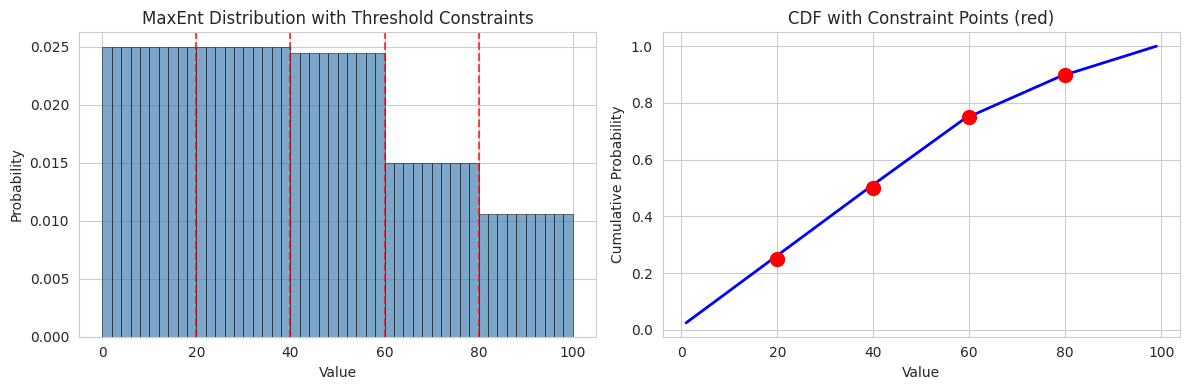

In [3]:
# Test 2: Multiple threshold constraints
constraint_set2 = ConstraintSet(
    domain_min=0,
    domain_max=100,
    n_bins=50,
)

# Add threshold constraints (simulating LLM responses)
thresholds = [
    (20, 0.75, "greater"),  # P(X > 20) = 0.75
    (40, 0.50, "greater"),  # P(X > 40) = 0.50
    (60, 0.25, "greater"),  # P(X > 60) = 0.25
    (80, 0.10, "greater"),  # P(X > 80) = 0.10
]

for threshold, prob, direction in thresholds:
    constraint_set2.add_threshold_constraint(
        threshold=threshold,
        probability=prob,
        direction=direction,
        confidence=0.9
    )

# Solve
solver2 = MaxEntSolver(SolverConfig(verbose=False))
distribution2, info2 = solver2.solve(constraint_set2)

bin_edges2 = constraint_set2.bin_edges
bin_centers2 = (bin_edges2[:-1] + bin_edges2[1:]) / 2

# Check constraint satisfaction
print("Constraint satisfaction:")
print("-" * 50)
cdf2 = np.cumsum(distribution2)
for threshold, target_prob, direction in thresholds:
    # Find bin index for threshold
    idx = np.searchsorted(bin_edges2[1:], threshold)
    if direction == "greater":
        actual_prob = 1 - cdf2[min(idx, len(cdf2)-1)]
    else:
        actual_prob = cdf2[min(idx, len(cdf2)-1)]
    print(f"P(X > {threshold}) = {target_prob:.2f} (target) vs {actual_prob:.2f} (actual)")

print(f"\nEntropy: {info2['entropy']:.4f}")
print(f"Total violation: {info2['total_violation']:.6f}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(bin_centers2, distribution2, width=bin_edges2[1]-bin_edges2[0], 
            alpha=0.7, edgecolor='black', linewidth=0.5, color='steelblue')
for threshold, prob, _ in thresholds:
    axes[0].axvline(threshold, color='red', linestyle='--', alpha=0.7)
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Probability')
axes[0].set_title('MaxEnt Distribution with Threshold Constraints')

# CDF with constraint points
axes[1].plot(bin_centers2, cdf2, 'b-', linewidth=2, label='CDF')
for threshold, prob, direction in thresholds:
    if direction == "greater":
        axes[1].scatter([threshold], [1-prob], color='red', s=100, zorder=5, marker='o')
    else:
        axes[1].scatter([threshold], [prob], color='red', s=100, zorder=5, marker='o')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Cumulative Probability')
axes[1].set_title('CDF with Constraint Points (red)')

plt.tight_layout()
plt.show()

## Test 3: Quantile Constraints

Testing with quantile constraints (median, quartiles).

Quantile constraint satisfaction:
--------------------------------------------------
Q(0.25) = 25 (target) vs 25.0 (actual)
Q(0.50) = 45 (target) vs 45.0 (actual)
Q(0.75) = 70 (target) vs 71.0 (actual)

Entropy: 3.9028
Total violation: 0.005775


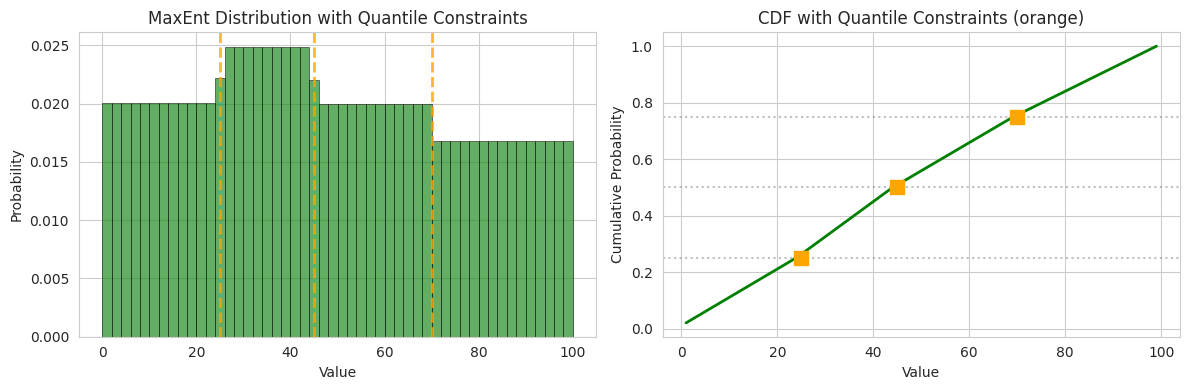

In [4]:
# Test 3: Quantile constraints
constraint_set3 = ConstraintSet(
    domain_min=0,
    domain_max=100,
    n_bins=50,
)

# Add quantile constraints (Q1, median, Q3)
quantiles = [
    (0.25, 25),   # Q1 = 25
    (0.50, 45),   # Median = 45
    (0.75, 70),   # Q3 = 70
]

for q, val in quantiles:
    constraint_set3.add_quantile_constraint(quantile=q, value=val, confidence=0.95)

# Solve
solver3 = MaxEntSolver(SolverConfig(verbose=False))
distribution3, info3 = solver3.solve(constraint_set3)

bin_edges3 = constraint_set3.bin_edges
bin_centers3 = (bin_edges3[:-1] + bin_edges3[1:]) / 2

# Check constraint satisfaction
print("Quantile constraint satisfaction:")
print("-" * 50)
cdf3 = np.cumsum(distribution3)
for q, target_val in quantiles:
    # Find actual quantile value
    idx = np.searchsorted(cdf3, q)
    actual_val = bin_centers3[min(idx, len(bin_centers3)-1)]
    print(f"Q({q:.2f}) = {target_val} (target) vs {actual_val:.1f} (actual)")

print(f"\nEntropy: {info3['entropy']:.4f}")
print(f"Total violation: {info3['total_violation']:.6f}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(bin_centers3, distribution3, width=bin_edges3[1]-bin_edges3[0], 
            alpha=0.7, edgecolor='black', linewidth=0.5, color='forestgreen')
for q, val in quantiles:
    axes[0].axvline(val, color='orange', linestyle='--', alpha=0.8, linewidth=2)
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Probability')
axes[0].set_title('MaxEnt Distribution with Quantile Constraints')

# CDF with quantile points
axes[1].plot(bin_centers3, cdf3, 'g-', linewidth=2, label='CDF')
for q, val in quantiles:
    axes[1].scatter([val], [q], color='orange', s=100, zorder=5, marker='s')
    axes[1].axhline(q, color='gray', linestyle=':', alpha=0.5)
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Cumulative Probability')
axes[1].set_title('CDF with Quantile Constraints (orange)')

plt.tight_layout()
plt.show()

/tmp/ipykernel_1089318/4146921272.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes.legend(fontsize=8)


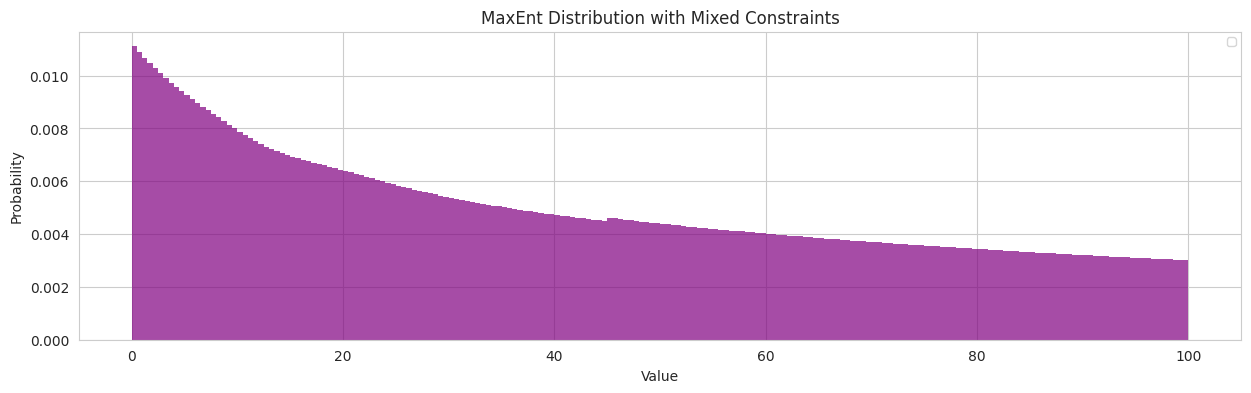

In [24]:
constraint_set4 = ConstraintSet(
    domain_min=0,
    domain_max=100,
    n_bins=200,  # Higher resolution
)

# Add various constraints
constraint_set4.add_mean_constraint(mean=40, confidence=0.8)
constraint_set4.add_quantile_constraint(quantile=0.5, value=45, confidence=0.9)  # Median slightly below mean
# constraint_set4.add_threshold_constraint(threshold=30, probability=0.7, direction="greater", confidence=0.85)
# constraint_set4.add_threshold_constraint(threshold=70, probability=0.25, direction="greater", confidence=0.85)

# Solve
solver4 = MaxEntSolver(SolverConfig(verbose=False, constraint_weight=1))
distribution4, info4 = solver4.solve(constraint_set4)

bin_edges4 = constraint_set4.bin_edges
bin_centers4 = (bin_edges4[:-1] + bin_edges4[1:]) / 2

fig, axes = plt.subplots(1, 1, figsize=(15, 4))
# PDF
axes.bar(bin_centers4, distribution4, width=bin_edges4[1]-bin_edges4[0], 
            alpha=0.7, edgecolor='none', color='purple')

axes.set_xlabel('Value')
axes.set_ylabel('Probability')
axes.set_title('MaxEnt Distribution with Mixed Constraints')
axes.legend(fontsize=8)
fig.show()

## Test 4: Mixed Constraints (Mean + Thresholds + Quantiles)

A more realistic scenario with multiple types of constraints.

Mixed constraint results:
--------------------------------------------------
Mean: 50 (target) vs 50.0 (actual)
Median: 45 (target) vs 47.5 (actual)
P(X > 30): 0.70 (target) vs 0.70 (actual)
P(X > 70): 0.25 (target) vs 0.26 (actual)

Entropy: 2.9484
Total violation: 0.012927
Constraint violations: {'mean_0': np.float64(0.00019089074194766908), 'quantile_1': np.float64(0.0055456122671978525), 'thresh_2': np.float64(0.0020813901519416422), 'thresh_3': np.float64(0.007075900771766008)}


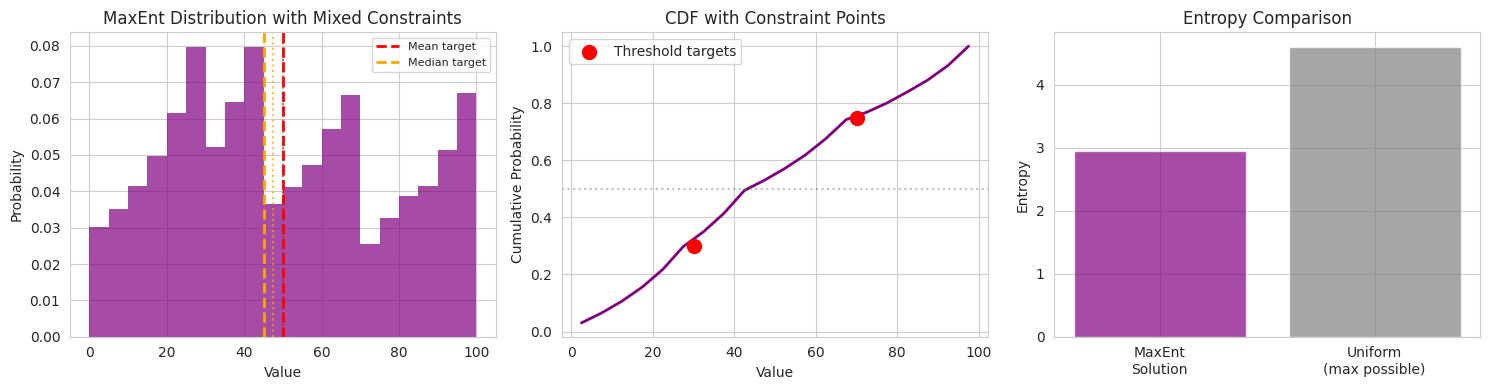

In [9]:
# Test 4: Mixed constraints
constraint_set4 = ConstraintSet(
    domain_min=0,
    domain_max=100,
    n_bins=20,  # Higher resolution
)

# Add various constraints
constraint_set4.add_mean_constraint(mean=50, confidence=0.8)
constraint_set4.add_quantile_constraint(quantile=0.5, value=45, confidence=0.9)  # Median slightly below mean
constraint_set4.add_threshold_constraint(threshold=30, probability=0.7, direction="greater", confidence=0.85)
constraint_set4.add_threshold_constraint(threshold=70, probability=0.25, direction="greater", confidence=0.85)

# Solve
solver4 = MaxEntSolver(SolverConfig(verbose=False, constraint_weight=150))
distribution4, info4 = solver4.solve(constraint_set4)

bin_edges4 = constraint_set4.bin_edges
bin_centers4 = (bin_edges4[:-1] + bin_edges4[1:]) / 2

# Calculate statistics
actual_mean = np.sum(distribution4 * bin_centers4)
cdf4 = np.cumsum(distribution4)
median_idx = np.searchsorted(cdf4, 0.5)
actual_median = bin_centers4[min(median_idx, len(bin_centers4)-1)]

print("Mixed constraint results:")
print("-" * 50)
print(f"Mean: 50 (target) vs {actual_mean:.1f} (actual)")
print(f"Median: 45 (target) vs {actual_median:.1f} (actual)")

# Check threshold constraints
for threshold, target_prob in [(30, 0.7), (70, 0.25)]:
    idx = np.searchsorted(bin_edges4[1:], threshold)
    actual_prob = 1 - cdf4[min(idx, len(cdf4)-1)]
    print(f"P(X > {threshold}): {target_prob:.2f} (target) vs {actual_prob:.2f} (actual)")

print(f"\nEntropy: {info4['entropy']:.4f}")
print(f"Total violation: {info4['total_violation']:.6f}")
print(f"Constraint violations: {info4['constraint_violations']}")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# PDF
axes[0].bar(bin_centers4, distribution4, width=bin_edges4[1]-bin_edges4[0], 
            alpha=0.7, edgecolor='none', color='purple')
axes[0].axvline(50, color='red', linestyle='--', label='Mean target', linewidth=2)
axes[0].axvline(45, color='orange', linestyle='--', label='Median target', linewidth=2)
axes[0].axvline(actual_mean, color='red', linestyle=':', alpha=0.7)
axes[0].axvline(actual_median, color='orange', linestyle=':', alpha=0.7)
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Probability')
axes[0].set_title('MaxEnt Distribution with Mixed Constraints')
axes[0].legend(fontsize=8)

# CDF
axes[1].plot(bin_centers4, cdf4, 'purple', linewidth=2)
axes[1].scatter([30, 70], [1-0.7, 1-0.25], color='red', s=100, zorder=5, label='Threshold targets')
axes[1].axhline(0.5, color='gray', linestyle=':', alpha=0.5)
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Cumulative Probability')
axes[1].set_title('CDF with Constraint Points')
axes[1].legend()

# Entropy comparison with uniform
uniform_entropy = np.log(100)  # Entropy of uniform distribution
axes[2].bar(['MaxEnt\nSolution', 'Uniform\n(max possible)'], 
            [info4['entropy'], uniform_entropy], color=['purple', 'gray'], alpha=0.7)
axes[2].set_ylabel('Entropy')
axes[2].set_title('Entropy Comparison')

plt.tight_layout()
plt.show()

## Test 5: Inconsistent Constraints

Testing how the solver handles conflicting constraints (soft constraint mode helps here).

Constraints are inconsistent:
  - Mean = 80 (want high values)
  - P(X < 50) = 0.8 (want most mass below 50)
  - Q(0.9) = 60 (90% of mass below 60)

Achieved values (compromise solution):
--------------------------------------------------
Mean: 80 (target) vs 80.0 (actual)
P(X < 50): 0.80 (target) vs 0.38 (actual)
Q(0.9): 60 (target) vs 99.0 (actual)

Total violation: 0.8132
Individual violations: {'mean_0': np.float64(0.022778031405408683), 'thresh_1': np.float64(0.42216867647062445), 'quantile_2': np.float64(0.5216818742519956)}
Achieved values (compromise solution):
--------------------------------------------------
Mean: 80 (target) vs 80.0 (actual)
P(X < 50): 0.80 (target) vs 0.38 (actual)
Q(0.9): 60 (target) vs 99.0 (actual)

Total violation: 0.8132
Individual violations: {'mean_0': np.float64(0.022778031405408683), 'thresh_1': np.float64(0.42216867647062445), 'quantile_2': np.float64(0.5216818742519956)}


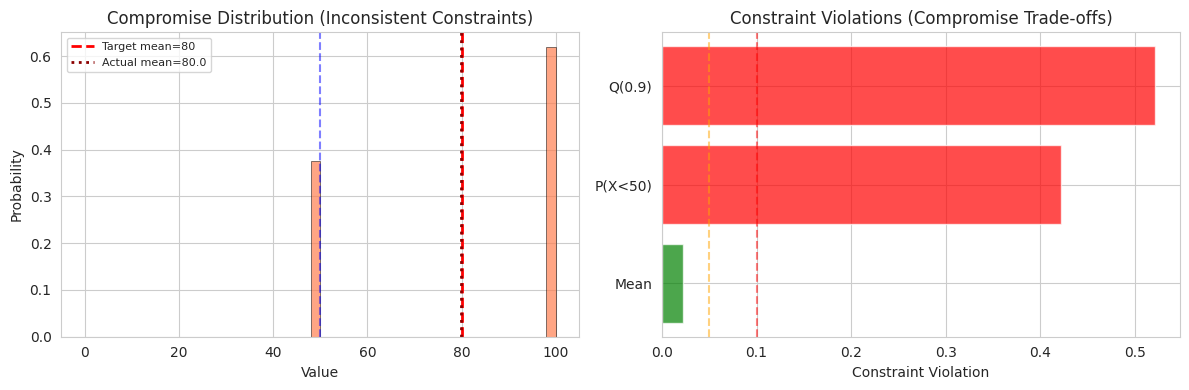

In [6]:
# Test 5: Inconsistent constraints
# These constraints are logically inconsistent - no distribution can satisfy them all

constraint_set5 = ConstraintSet(
    domain_min=0,
    domain_max=100,
    n_bins=50,
)

# Conflicting constraints
constraint_set5.add_mean_constraint(mean=80, confidence=0.7)  # High mean
constraint_set5.add_threshold_constraint(threshold=50, probability=0.8, direction="less", confidence=0.9)  # Most mass below 50
constraint_set5.add_quantile_constraint(quantile=0.9, value=60, confidence=0.8)  # 90th percentile at 60

print("Constraints are inconsistent:")
print("  - Mean = 80 (want high values)")
print("  - P(X < 50) = 0.8 (want most mass below 50)")
print("  - Q(0.9) = 60 (90% of mass below 60)")
print()

# Solve
solver5 = MaxEntSolver(SolverConfig(verbose=False, use_soft_constraints=True))
distribution5, info5 = solver5.solve(constraint_set5)

bin_edges5 = constraint_set5.bin_edges
bin_centers5 = (bin_edges5[:-1] + bin_edges5[1:]) / 2

# Calculate achieved values
actual_mean = np.sum(distribution5 * bin_centers5)
cdf5 = np.cumsum(distribution5)
idx_50 = np.searchsorted(bin_edges5[1:], 50)
prob_below_50 = cdf5[min(idx_50, len(cdf5)-1)]
q90_idx = np.searchsorted(cdf5, 0.9)
actual_q90 = bin_centers5[min(q90_idx, len(bin_centers5)-1)]

print("Achieved values (compromise solution):")
print("-" * 50)
print(f"Mean: 80 (target) vs {actual_mean:.1f} (actual)")
print(f"P(X < 50): 0.80 (target) vs {prob_below_50:.2f} (actual)")
print(f"Q(0.9): 60 (target) vs {actual_q90:.1f} (actual)")
print(f"\nTotal violation: {info5['total_violation']:.4f}")
print(f"Individual violations: {info5['constraint_violations']}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(bin_centers5, distribution5, width=bin_edges5[1]-bin_edges5[0], 
            alpha=0.7, edgecolor='black', linewidth=0.5, color='coral')
axes[0].axvline(80, color='red', linestyle='--', label='Target mean=80', linewidth=2)
axes[0].axvline(actual_mean, color='darkred', linestyle=':', label=f'Actual mean={actual_mean:.1f}', linewidth=2)
axes[0].axvline(50, color='blue', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Probability')
axes[0].set_title('Compromise Distribution (Inconsistent Constraints)')
axes[0].legend(fontsize=8)

# Show constraint violations
violations = list(info5['constraint_violations'].values())
labels = ['Mean', 'P(X<50)', 'Q(0.9)']
colors = ['red' if v > 0.1 else 'orange' if v > 0.05 else 'green' for v in violations]
axes[1].barh(labels, violations, color=colors, alpha=0.7)
axes[1].set_xlabel('Constraint Violation')
axes[1].set_title('Constraint Violations (Compromise Trade-offs)')
axes[1].axvline(0.1, color='red', linestyle='--', alpha=0.5, label='High violation')
axes[1].axvline(0.05, color='orange', linestyle='--', alpha=0.5, label='Medium violation')

plt.tight_layout()
plt.show()

## Test 6: Confidence Weighting

Testing how different confidence levels affect constraint satisfaction.

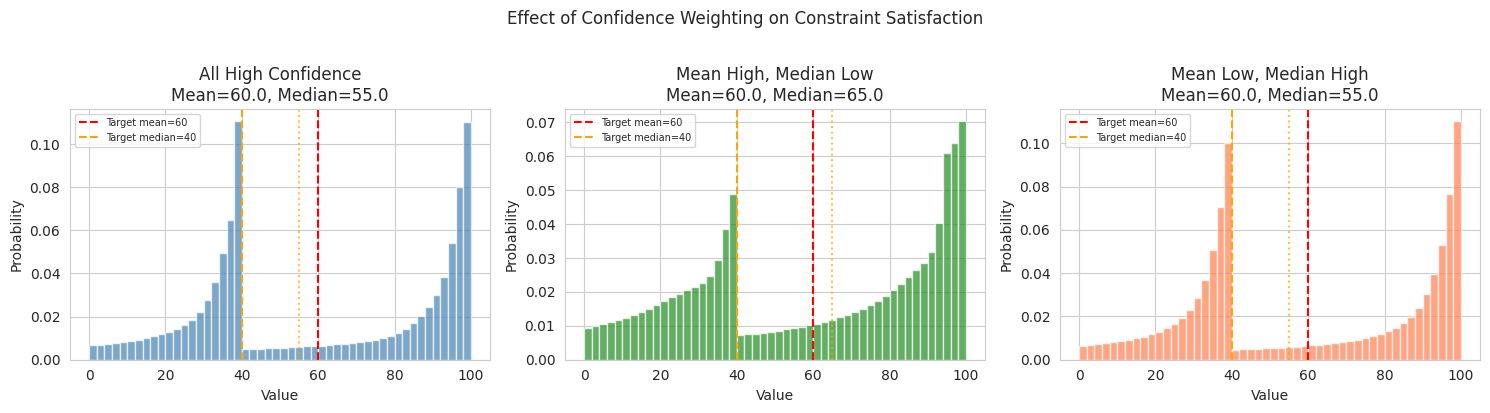


Summary:
------------------------------------------------------------
Config                     Actual Mean  Actual Median    Entropy
------------------------------------------------------------
All High Confidence               60.0           55.0     3.4171
Mean High, Median Low             60.0           65.0     3.7048
Mean Low, Median High             60.0           55.0     3.4303


In [7]:
# Test 6: Confidence weighting - same constraints with different confidence levels
results = []

# Run with different confidence configurations
configs = [
    ("All High Confidence", [1.0, 1.0]),
    ("Mean High, Median Low", [1.0, 0.2]),
    ("Mean Low, Median High", [0.2, 1.0]),
]

for name, (mean_conf, median_conf) in configs:
    cs = ConstraintSet(domain_min=0, domain_max=100, n_bins=50)
    cs.add_mean_constraint(mean=60, confidence=mean_conf)
    cs.add_quantile_constraint(quantile=0.5, value=40, confidence=median_conf)  # Conflicting median
    
    solver = MaxEntSolver(SolverConfig(verbose=False))
    dist, info = solver.solve(cs)
    
    bin_centers = (cs.bin_edges[:-1] + cs.bin_edges[1:]) / 2
    actual_mean = np.sum(dist * bin_centers)
    cdf = np.cumsum(dist)
    median_idx = np.searchsorted(cdf, 0.5)
    actual_median = bin_centers[min(median_idx, len(bin_centers)-1)]
    
    results.append({
        'name': name,
        'distribution': dist,
        'actual_mean': actual_mean,
        'actual_median': actual_median,
        'entropy': info['entropy'],
    })

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
colors = ['steelblue', 'forestgreen', 'coral']

for i, (res, color) in enumerate(zip(results, colors)):
    bin_centers = np.linspace(1, 99, 50)
    axes[i].bar(bin_centers, res['distribution'], width=2, alpha=0.7, color=color)
    axes[i].axvline(60, color='red', linestyle='--', label=f"Target mean=60")
    axes[i].axvline(40, color='orange', linestyle='--', label=f"Target median=40")
    axes[i].axvline(res['actual_mean'], color='red', linestyle=':', alpha=0.7)
    axes[i].axvline(res['actual_median'], color='orange', linestyle=':', alpha=0.7)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Probability')
    axes[i].set_title(f"{res['name']}\nMean={res['actual_mean']:.1f}, Median={res['actual_median']:.1f}")
    axes[i].legend(fontsize=7)

plt.suptitle('Effect of Confidence Weighting on Constraint Satisfaction', y=1.02)
plt.tight_layout()
plt.show()

# Summary table
print("\nSummary:")
print("-" * 60)
print(f"{'Config':<25} {'Actual Mean':>12} {'Actual Median':>14} {'Entropy':>10}")
print("-" * 60)
for res in results:
    print(f"{res['name']:<25} {res['actual_mean']:>12.1f} {res['actual_median']:>14.1f} {res['entropy']:>10.4f}")

## Test 7: Increasing Number of Constraints

Testing how the solver handles progressively more constraints and how entropy decreases.